# **[REGRESSION WITH A FLOOD PREDICTION DATASET](https://www.kaggle.com/competitions/playground-series-s4e5/data)**  

### The goal of this competition is to predict the probability of a region flooding based on 20 factors: MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization, ClimateChange, DamsQuality, Siltation, AgriculturalPractices, Encroachments, IneffectiveDisasterPreparedness, DrainageSystems, CoastalVulnerability, Landslides, Watersheds, DeterioratingInfrastructure, PopulationScore, WetlandLoss, InadequatePlanning and PoliticalFactors.  

### The datasets for this competition (both train and test) were generated from a deep learning model trained on the [Flood Prediction Factors dataset](https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors).

### Submissions are evaluated using the R2 score.  


In this notebook we'll perform:   
* EDA, 
* Feature engineering,  
* Linear models training with linear, ridge and lasso regressors, and  
* Tree-based models training with Histogram-based Gradient Boosting Regression Tree, XGBoost, LightGBM and CatBoost regressors.

## **IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
import scipy

import os
import psutil
import gc
import platform
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator

import statsmodels.api as sm
from scipy import stats

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.compose import ColumnTransformer

# Remove the max column restriction for displaying on the screen
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

print('Package versions:')
print('- Python', platform.python_version())
for package in [pd, np, matplotlib, sns, sklearn, scipy, sm, xgb, lgbm, catb]:
    print ('-', package.__name__, package.__version__)
print()
    
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from IPython.display import Markdown as md

Package versions:
- Python 3.10.13
- pandas 2.2.2
- numpy 1.26.4
- matplotlib 3.7.5
- seaborn 0.12.2
- sklearn 1.2.2
- scipy 1.11.4
- statsmodels.api 0.14.1
- xgboost 2.0.3
- lightgbm 4.2.0
- catboost 1.2.3

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
# Helper functions

import random as py_random

def reset_random_seeds(seed=42):
    ''' Set all seeds for random numbers to get reproducibility.'''
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    py_random.seed(seed)


reset_random_seeds()

In [3]:
# DEFINE GLOBAL VARIABLES

N_FOLDS                = 5      # Number of folds for cross-validation
VALIDATION_SCORES      = dict() # oof scores generated by different models
VALIDATION_BEST_MODELS = dict() # top scoring models generated through cross-validation

## **LOAD TRAIN AND TEST SETS**

In [4]:
def read_csv_file(path, is_train=True):
    
    df = pd.read_csv(path, index_col='id')  
    if is_train: 
        df[df.columns[:-1]] = df[df.columns[:-1]].astype(np.uint8)
    else:
        df = df.astype(np.uint8)
    return df

In [5]:
train = read_csv_file('/kaggle/input/playground-series-s4e5/train.csv')
test  = read_csv_file('/kaggle/input/playground-series-s4e5/test.csv', is_train=False)

initial_features = train.columns[:-1].to_list()

print('train shape =', train.shape,'(including target)')
print('test shape  =', test.shape)
print('\ntrain:')
train.head()

train shape = (1117957, 21) (including target)
test shape  = (745305, 20)

train:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## **EXPLORATORY DATA ANALYSIS**

In [6]:
display(md(f'''
**Number of features = {len(initial_features)}**   

**Train shape = {train.shape} (including target)**           
Number of missing values in train set = {train.isna().sum().sum()}   
Number of duplicates rows in train set = {sum(train[initial_features].duplicated())}   

**Test shape = {test.shape}**     
Number of missing values in test set = {test.isna().sum().sum()}   

**Train info:**
'''))

train.info()


**Number of features = 20**   

**Train shape = (1117957, 21) (including target)**           
Number of missing values in train set = 0   
Number of duplicates rows in train set = 0   

**Test shape = (745305, 20)**     
Number of missing values in test set = 0   

**Train info:**


<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  uint8  
 1   TopographyDrainage               1117957 non-null  uint8  
 2   RiverManagement                  1117957 non-null  uint8  
 3   Deforestation                    1117957 non-null  uint8  
 4   Urbanization                     1117957 non-null  uint8  
 5   ClimateChange                    1117957 non-null  uint8  
 6   DamsQuality                      1117957 non-null  uint8  
 7   Siltation                        1117957 non-null  uint8  
 8   AgriculturalPractices            1117957 non-null  uint8  
 9   Encroachments                    1117957 non-null  uint8  
 10  IneffectiveDisasterPreparedness  1117957 non-null  uint8  
 11  DrainageSystems                  1117957 non-null  uint

In [7]:
display(md(f'''
**All features are categorical** with median equal to {int(train[initial_features].agg('median').unique()[0])}. 
For most features, mode and median are equal.    
'''))

# Compute min, max, median, mode and the number of unique values for each feature in train set
display(pd.concat([train[initial_features].agg(['nunique', 'min', 'max', 'median']), train[initial_features].agg('mode')], axis=0).T.rename({0:'mode'}, axis=1).astype(int))


def check_correlative_numbers(df_as_string):
    '''It checks if the unique values of each feature are correlative.'''
    
    check = lambda x: x['nunique'] - (x['max'] - x['min'] + 1)
    features_check = globals()[df_as_string][initial_features].agg(['nunique', 'min', 'max'], axis=0).T.agg(check, axis=1)
    features_no_correlative = features_check[features_check!=0].index.to_list()
    display(md(f'All features have correlative integer values in {df_as_string} set = {str(len(features_no_correlative)==0)}'))
    
    
def check_values_not_in_intersection(df1_as_string, df2_as_string):
    '''For each feature, it checks if the elements in two datasets are identical.'''
    
    unique_set = lambda x: set(x.unique())
    features_set_1 = globals()[df1_as_string][initial_features].agg(unique_set, axis=0)
    features_set_2 = globals()[df2_as_string][initial_features].agg(unique_set, axis=0)
    dict_1 = {}
    dict_2 = {}
    for col in initial_features: 
        dict_1[col] = [v for v in features_set_1[col] if v not in features_set_2[col]]
        dict_2[col] = [v for v in features_set_2[col] if v not in features_set_1[col]]
    in_1_not_in_2 = {k:dict_1[k] for k in dict_1 if len(dict_1[k])>0}
    in_2_not_in_1 = {k:dict_2[k] for k in dict_2 if len(dict_2[k])>0}

    display(md(f'(Features, list of integer values) present in {df1_as_string} set but not in {df2_as_string} set = {in_1_not_in_2}'))
    display(md(f'(Features, list of integer values) present in {df2_as_string} set but not in {df1_as_string} set = {in_2_not_in_1}'))
    
    return in_1_not_in_2, in_2_not_in_1 

print()
check_correlative_numbers('train')
check_correlative_numbers('test')
print()
_, in_2_not_in_1 = check_values_not_in_intersection('train', 'test')
print()
display(md(f'Max values for {list(in_2_not_in_1.keys())} in train set are:'))
train[in_2_not_in_1.keys()].agg(['max'], axis=0).T


**All features are categorical** with median equal to 5. 
For most features, mode and median are equal.    


,nunique,min,max,median,mode
MonsoonIntensity,17,0,16,5,5
TopographyDrainage,19,0,18,5,5
RiverManagement,17,0,16,5,5
Deforestation,18,0,17,5,4
Urbanization,18,0,17,5,5
ClimateChange,18,0,17,5,5
DamsQuality,17,0,16,5,5
Siltation,17,0,16,5,5
AgriculturalPractices,17,0,16,5,5
Encroachments,19,0,18,5,5


All features have correlative integer values in train set = True

All features have correlative integer values in test set = False

(Features, list of integer values) present in train set but not in test set = {'TopographyDrainage': [18], 'Encroachments': [18], 'WetlandLoss': [19]}

(Features, list of integer values) present in test set but not in train set = {'PopulationScore': [19], 'WetlandLoss': [22]}

Max values for ['PopulationScore', 'WetlandLoss'] in train set are:

,max
PopulationScore,18
WetlandLoss,19


### HISTOGRAMS FOR TRAIN AND TEST SETS


Train and test datasets have **features with almost identical distributions**.    

As commented by @VLADA in the [<u>discussion group</u>](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499244), 
**all features come from Poisson distribution (lambda=5)** and there is strong evidence that the **original dataset was created artificially**.
<br><br>


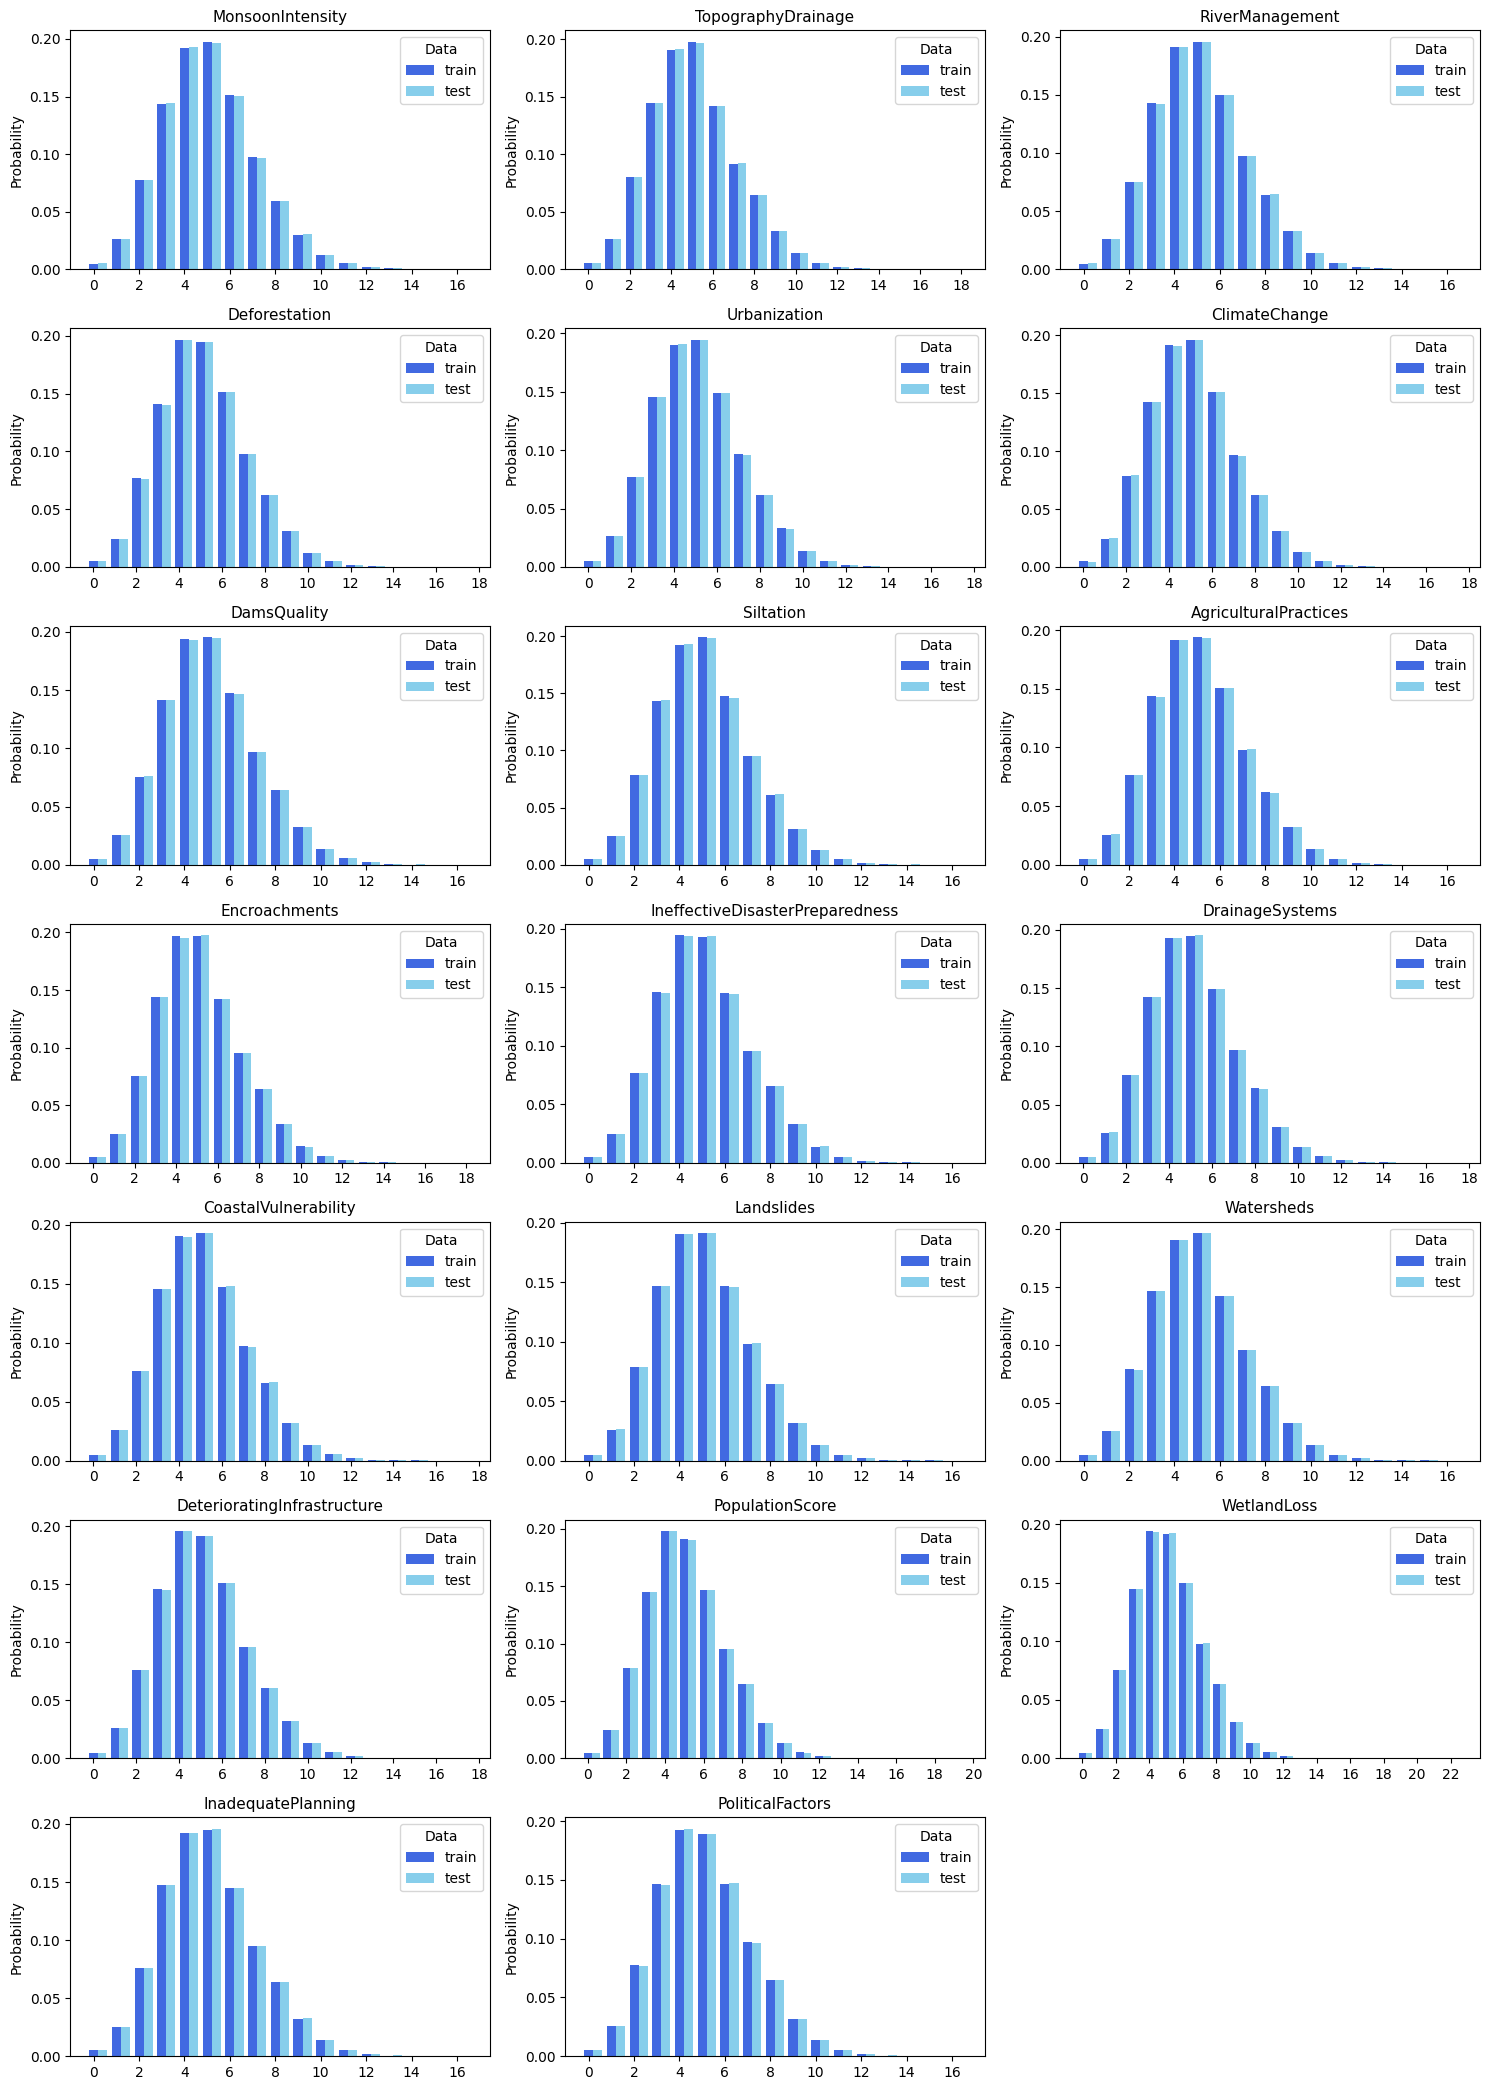

In [8]:
def plot_histograms(features, data_train, data_test, cols_number=3):
    '''It plots histograms for train and test datasets side by side.'''

    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)

    fig, axs = plt.subplots(rows_number, cols_number, figsize=(5*cols_number, 3*rows_number))
    axs      = axs.ravel()
    width    = 0.4 # bar width

    for col,ax in zip(features, axs):
        hist_train = train[col].value_counts(normalize=True)
        hist_test = test[col].value_counts(normalize=True)
        
        ax.bar(hist_train.index, hist_train.values, width=width, color='royalblue', align='center', fill=True, label='train')
        ax.bar(hist_test.index+width, hist_test.values, width=width, color='skyblue', align='center', fill=True, label='test')

        ax.set_title(col, fontsize = 11)
        
        ax.set_xlabel('')
        ax.set_ylabel('Probability')
        ax.legend(loc='upper right', title='Data')
        
        # center positions of xticks
        ax.xaxis.set_major_locator(MultipleLocator(2))
        n_xticks = np.arange(max(hist_train.index.to_list() + hist_test.index.to_list())+1) 
        plt.xticks(n_xticks + width / 2, n_xticks)

    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    fig.tight_layout()


display(md('''
Train and test datasets have **features with almost identical distributions**.    

As commented by @VLADA in the [<u>discussion group</u>](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499244), 
**all features come from Poisson distribution (lambda=5)** and there is strong evidence that the **original dataset was created artificially**.
<br><br>
'''))

plot_histograms(features=initial_features, data_train=train, data_test=test, cols_number=3)

In [9]:
display(md('''
<h3>Performing K-Sample Anderson-Darling Test to compare two discrete distributions with different sizes, 
computing A2akN according to equation 6 of Scholz & Stephens.</h3>      

After performing an Anderson-Darling K-Sample test for each feature of train and test datasets, 
where the null hypothesis is that each feature of those datasets comes from the same unknown distribution, 
we do not find sufficient evidence to support the alternative hypothesis (the feature comes from different distributions); 
therefore, we fail to reject the null hypothesis for all features.

<u>Obs</u>: This test can deal with discrete samples and tied observations.

<u>Ref</u>: Scholz, F. W and Stephens, M. A. (1987), K-Sample Anderson-Darling Tests, 
Journal of the American Statistical Association, Vol. 82, pp. 918-924. 
Paper available [<u>here</u>](https://faculty.washington.edu/fscholz/Papers/ADk.pdf)     
<br>

**Let's perform the test:**   
*H0 : two samples come from the same distribution.   
H0 is rejected if the T statistic is greater than or equal to the critical value at the 5% significance level.*    

**Results:**     
'''))

# apply test for each feature
for col in initial_features:
    res = stats.anderson_ksamp([train[col], test[col]], midrank=False)
    T = res.statistic # the statistic value
    critical_value = res.critical_values[2] # this is the critical value at significance level 5%
    text = 'H0 is rejected' if T >= critical_value else 'We fail to reject H0'
    display(md(f'- {col}: T = {T:.2f}, critical value at significance level 5% = {critical_value:.2f} ==> {text}'))

md('**Conclusion: we fail to reject the null hypothesis for all features.**')


<h3>Performing K-Sample Anderson-Darling Test to compare two discrete distributions with different sizes, 
computing A2akN according to equation 6 of Scholz & Stephens.</h3>      

After performing an Anderson-Darling K-Sample test for each feature of train and test datasets, 
where the null hypothesis is that each feature of those datasets comes from the same unknown distribution, 
we do not find sufficient evidence to support the alternative hypothesis (the feature comes from different distributions); 
therefore, we fail to reject the null hypothesis for all features.

<u>Obs</u>: This test can deal with discrete samples and tied observations.

<u>Ref</u>: Scholz, F. W and Stephens, M. A. (1987), K-Sample Anderson-Darling Tests, 
Journal of the American Statistical Association, Vol. 82, pp. 918-924. 
Paper available [<u>here</u>](https://faculty.washington.edu/fscholz/Papers/ADk.pdf)     
<br>

**Let's perform the test:**   
*H0 : two samples come from the same distribution.   
H0 is rejected if the T statistic is greater than or equal to the critical value at the 5% significance level.*    

**Results:**     


- MonsoonIntensity: T = 1.65, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- TopographyDrainage: T = -0.14, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- RiverManagement: T = 1.61, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Deforestation: T = -0.36, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Urbanization: T = 1.05, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- ClimateChange: T = -0.94, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- DamsQuality: T = 1.10, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Siltation: T = -0.40, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- AgriculturalPractices: T = 0.63, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Encroachments: T = 0.05, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- IneffectiveDisasterPreparedness: T = -0.19, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- DrainageSystems: T = -0.52, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- CoastalVulnerability: T = -0.17, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Landslides: T = -0.27, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- Watersheds: T = -0.94, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- DeterioratingInfrastructure: T = -1.09, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- PopulationScore: T = -1.01, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- WetlandLoss: T = -0.45, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- InadequatePlanning: T = -0.81, critical value at significance level 5% = 1.96 ==> We fail to reject H0

- PoliticalFactors: T = 1.77, critical value at significance level 5% = 1.96 ==> We fail to reject H0

**Conclusion: we fail to reject the null hypothesis for all features.**

### BOX PLOTS FOR TRAIN SET


**All features have the same value for the upper quartile**, which is unusual and is probably due to the artificial nature of the dataset.   
<br>


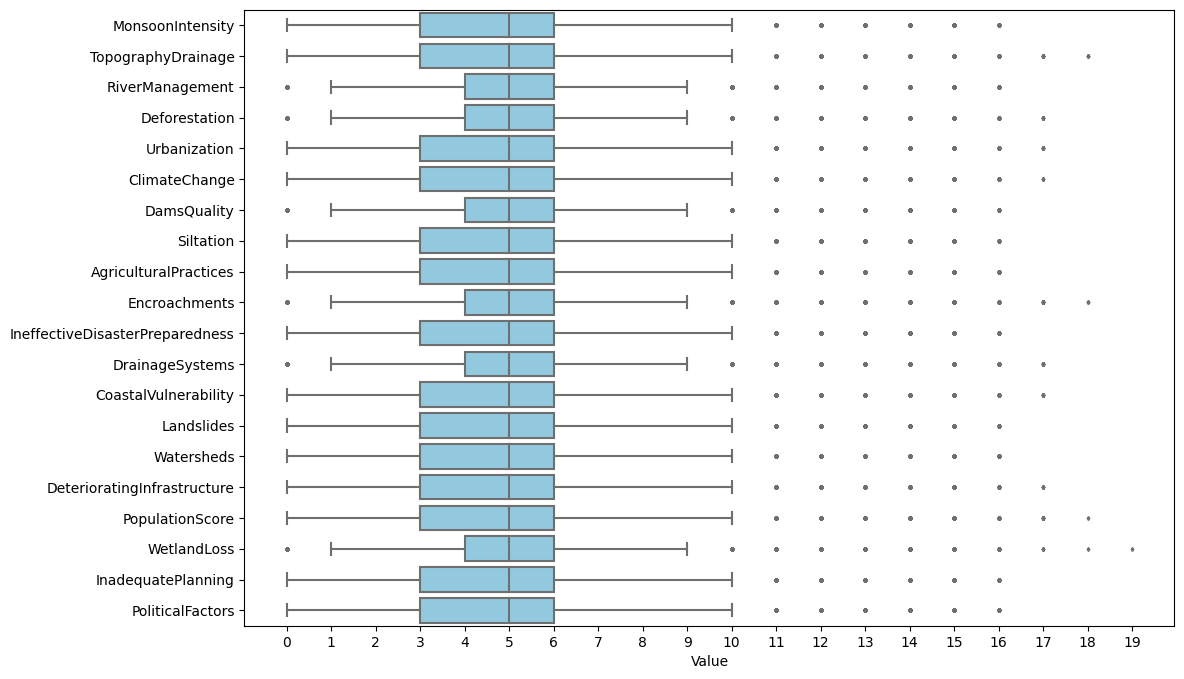

In [10]:
def draw_box_plots(df, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    ax = sns.boxplot(data=df[initial_features], orient="h", color='skyblue', fliersize=2)
    ax.set_xlabel('Value')
    ax.xaxis.set_major_locator(MultipleLocator(1))
    
    
display(md('''
**All features have the same value for the upper quartile**, which is unusual and is probably due to the artificial nature of the dataset.   
<br>
'''))

draw_box_plots(train, figsize=(12, 8))

### BIVARIATE ANALYSIS FOR TRAIN SET


In general, if for each feature we consider its discrete values in ascending order, 
we find that **the median value of FloodProbability increases smoothly with those discrete values sorted.**   
<br><br>


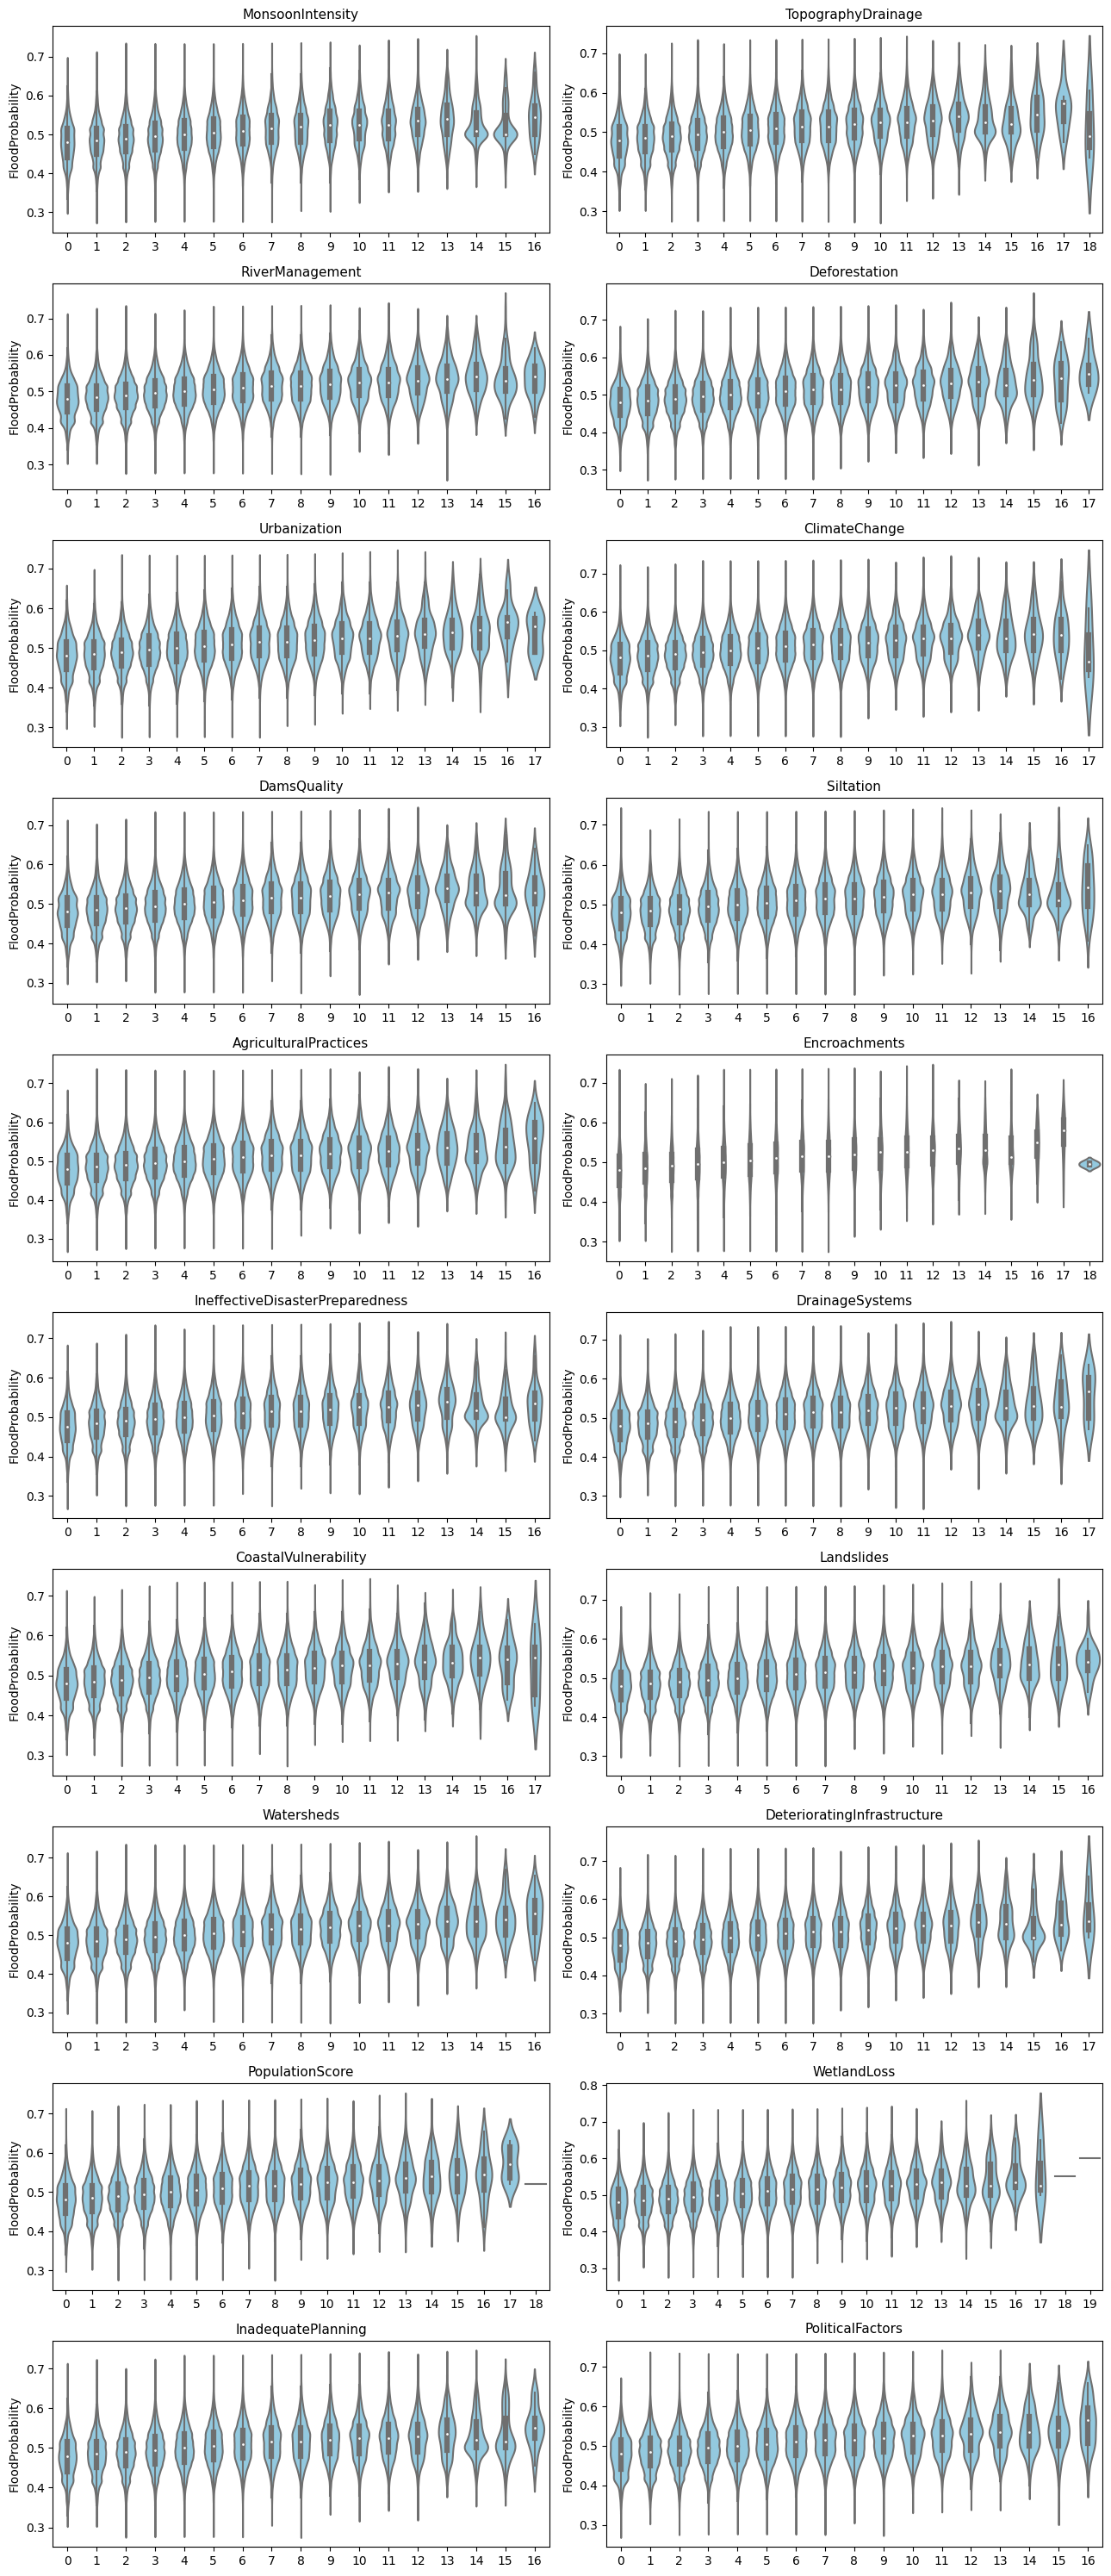

In [11]:
def plot_bivariate(features, df, cols_number=3):
    '''It plots violin plots for each feature vs FloodProbability.'''
    
    rows_number = len(features)//cols_number + min(1, len(features)%cols_number)

    fig, axs = plt.subplots(rows_number, cols_number, figsize=(6.5*cols_number, 3.0*rows_number))
    axs      = axs.ravel()

    for col,ax in zip(features, axs):
        sns.violinplot(data=df, x=col, y='FloodProbability', ax=ax, color='skyblue')  
        ax.set_title(col, fontsize = 11)
        ax.set_xlabel('')

    for i in range(len(features), rows_number*cols_number):
        axs[i].axis('off')
    fig.tight_layout()
    
#sns.catplot(data=train, x='MonsoonIntensity', y='FloodProbability', color='skyblue', kind='boxen', estimator='mean')  

display(md('''
In general, if for each feature we consider its discrete values in ascending order, 
we find that **the median value of FloodProbability increases smoothly with those discrete values sorted.**   
<br><br>
'''))

plot_bivariate(features=initial_features, df=train, cols_number=2)

### TARGET DISTRIBUTION


**FloodProbability has only 83 unique real values** out of a total of 1117957 records in the train set, 
**ranging from 0.285 up to 0.725**   

mean = 0.504 and median = 0.505 are almost identical, 
but mode = 0.490 differs a little.

**FloodProbability distribution looks quite normal**. 
In fact, if we look at its associated histogram and quantile-quantile plot (Q-Q plot for short), we cannot see any deviation from normality:   
- the histogram shows the bell-shaped curve of the normal distribution. If we estimate the normal distribution parameters from FloodProbability, 
we can plot the Kernel Density Estimation (KDE for short), where we observe an almost perfect match between the density for 
the estimated normal (the red line) and the estimated density for FloodProbability (the dark blue line); and        
- we see a straight diagonal blue line on the Q-Q plot, although the tails are little shorter than would be expected from a normal distribution.   

<u>Obs:</u> Normality tests are not reliable for very large datasets.   

<br>


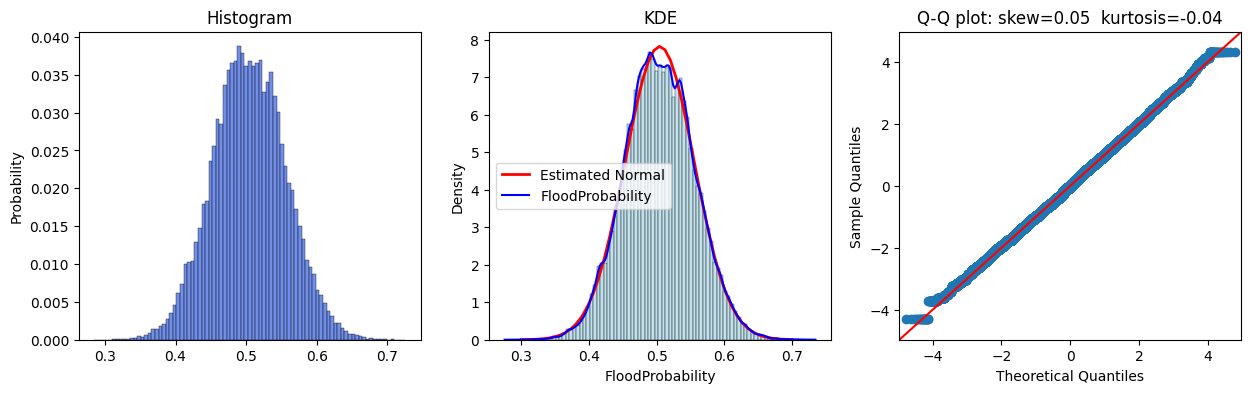

In [12]:
def plot_hist_qqplot(x):
    '''It plots histogram, KDE and Q-Q plot for FloodProbability.'''
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # histogram
    sns.histplot(x, ax=ax1, stat='probability', color='royalblue', bins=87).set(title='Histogram')
    ax1.set_xlabel('')
    
    # kde
    est_normal_x = np.linspace(0.3, 0.7)
    est_normal_y = stats.norm(*stats.norm.fit(x)).pdf(est_normal_x)
    sns.lineplot(x=est_normal_x, y=est_normal_y, ax=ax2, color='r', lw=2.0, label='Estimated Normal')
    sns.histplot(x, ax=ax2, stat='density', color='lightblue', kde=False, bins=87)
    sns.kdeplot(x, ax=ax2, color='b', label='FloodProbability').set(title='KDE')
    ax2.legend(loc='center left', title='')
    
    # q-q plot
    skew_text = 'Q-Q plot: skew=' + str(np.round(stats.skew(x),2)) + '  kurtosis=' + str(np.round(stats.kurtosis(x),2))
    sm.qqplot(x, fit=True, line='45', dist=stats.norm, ax=ax3)
    ax3.set_title(skew_text)


display(md(f'''
**FloodProbability has only {train.FloodProbability.nunique()} unique real values** out of a total of {len(train)} records in the train set, 
**ranging from {train.FloodProbability.min()} up to {train.FloodProbability.max()}**   

mean = {train.FloodProbability.mean():.3f} and median = {train.FloodProbability.median():.3f} are almost identical, 
but mode = {train.FloodProbability.mode()[0]:.3f} differs a little.

**FloodProbability distribution looks quite normal**. 
In fact, if we look at its associated histogram and quantile-quantile plot (Q-Q plot for short), we cannot see any deviation from normality:   
- the histogram shows the bell-shaped curve of the normal distribution. If we estimate the normal distribution parameters from FloodProbability, 
we can plot the Kernel Density Estimation (KDE for short), where we observe an almost perfect match between the density for 
the estimated normal (the red line) and the estimated density for FloodProbability (the dark blue line); and        
- we see a straight diagonal blue line on the Q-Q plot, although the tails are little shorter than would be expected from a normal distribution.   

<u>Obs:</u> Normality tests are not reliable for very large datasets.   

<br>
'''))

plot_hist_qqplot(train.FloodProbability)

### CORRELATION MATRIX ON TRAINING SET


As said in [<u>scipy stats</u>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.spearmanr.html#scipy.stats.mstats.spearmanr): 
"*The Spearman correlation is a nonparametric measure of the linear relationship between two datasets. Unlike the Pearson correlation, 
the Spearman correlation does not assume that both datasets are normally distributed.*"   

So, since we know that no feature comes from a normal distribution and assuming that all features are ordinal, which is not certain to be the case, 
we are going to calculate a correlation matrix with the Spearman method.

Analyzing the results we can conclude that **if all features were ordinal, they would have a very low correlation with each other. 
The same could be said for the correlation between features and FloodProbability.** 
<br><br>


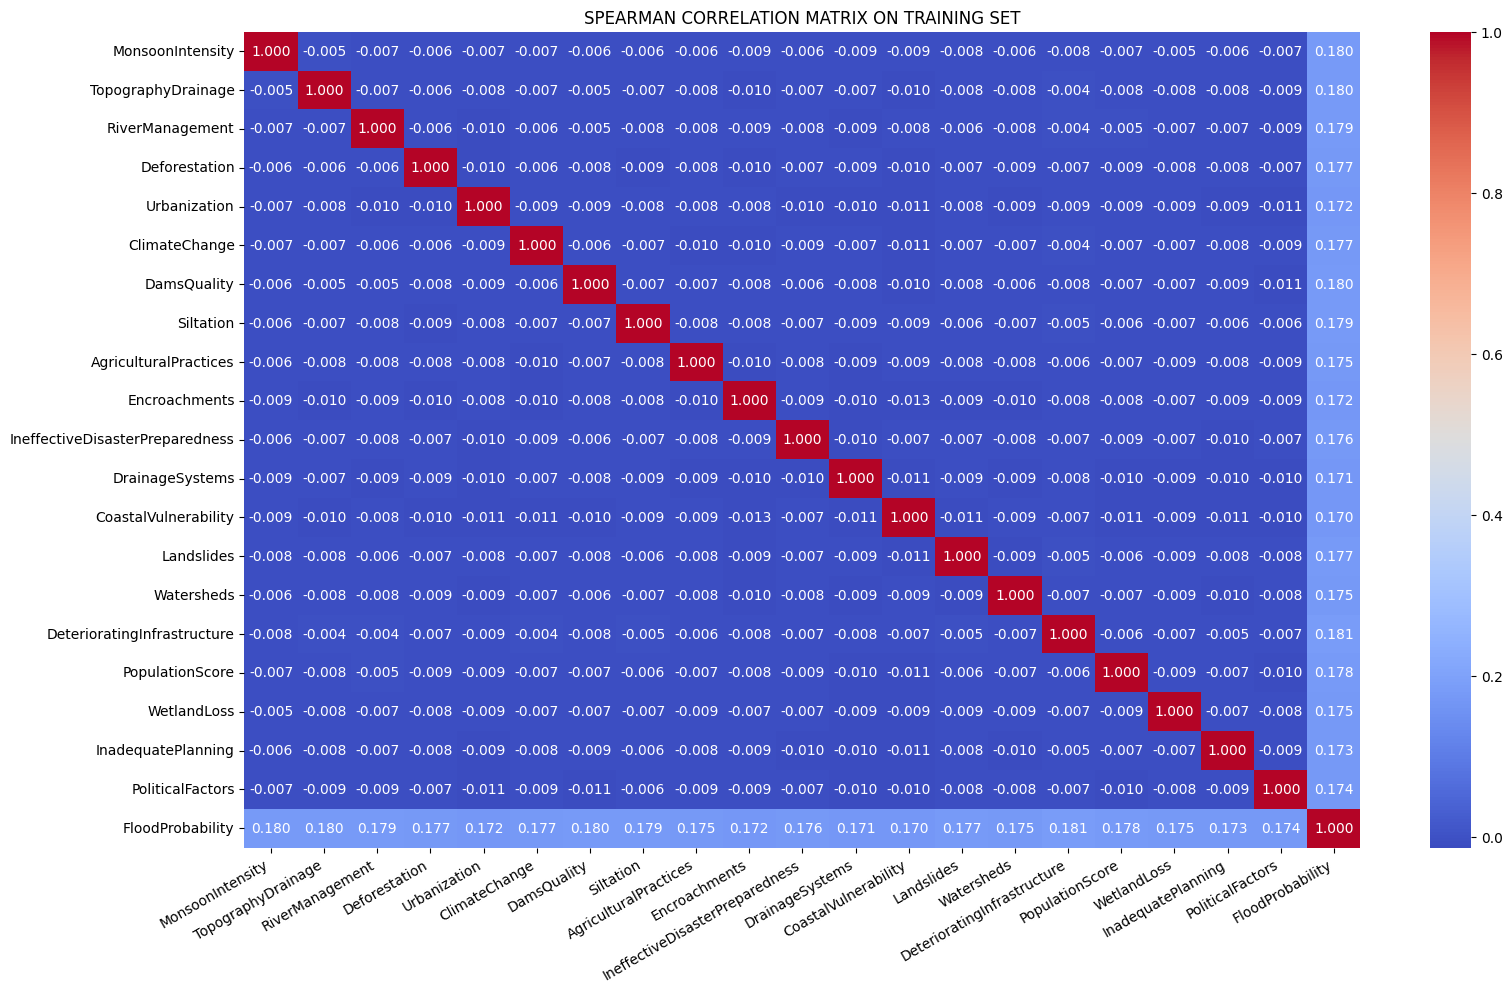

In [13]:
def plot_correlation_matrix(df, corr_cols, figsize, method='spearman', criteria=None, text=''):
    '''It plots correlation matrix with Spearman method.'''
    
    if criteria is None:
        corr_matrix = df[corr_cols].corr(method=method)
    else:    
        corr_matrix = df.loc[criteria,corr_cols].corr(method=method)
    fig = plt.figure(figsize=figsize)
    ax= sns.heatmap(corr_matrix, annot=True, fmt=',.3f', cmap='coolwarm')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
    ax.set_title(method.upper() + ' CORRELATION MATRIX ' + text)
    fig.autofmt_xdate() # it helps to rotate ticklabels if they are long
    

display(md('''
As said in [<u>scipy stats</u>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.spearmanr.html#scipy.stats.mstats.spearmanr): 
"*The Spearman correlation is a nonparametric measure of the linear relationship between two datasets. Unlike the Pearson correlation, 
the Spearman correlation does not assume that both datasets are normally distributed.*"   

So, since we know that no feature comes from a normal distribution and assuming that all features are ordinal, which is not certain to be the case, 
we are going to calculate a correlation matrix with the Spearman method.

Analyzing the results we can conclude that **if all features were ordinal, they would have a very low correlation with each other. 
The same could be said for the correlation between features and FloodProbability.** 
<br><br>
'''))

plot_correlation_matrix(df=train, corr_cols=initial_features+['FloodProbability'], figsize=(18,12), method='spearman', text='ON TRAINING SET')

## **MODELS**

### FEATURE ENGINEERING


As commented by @AMBROSM in the notebook [<u>"PSS4E5 EDA which makes sense"</u>](https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense?scriptVersionId=176598272&cellId=26), 
assuming that all variables were continuous, the linear regression analysis showed that **there was a high correlation between the sum of all features and FloodProbability**, 
with $R^2 = 0.844$ (approx). That's why in that notebook, the sum of all the features was proposed as a new feature.   

<br><br>


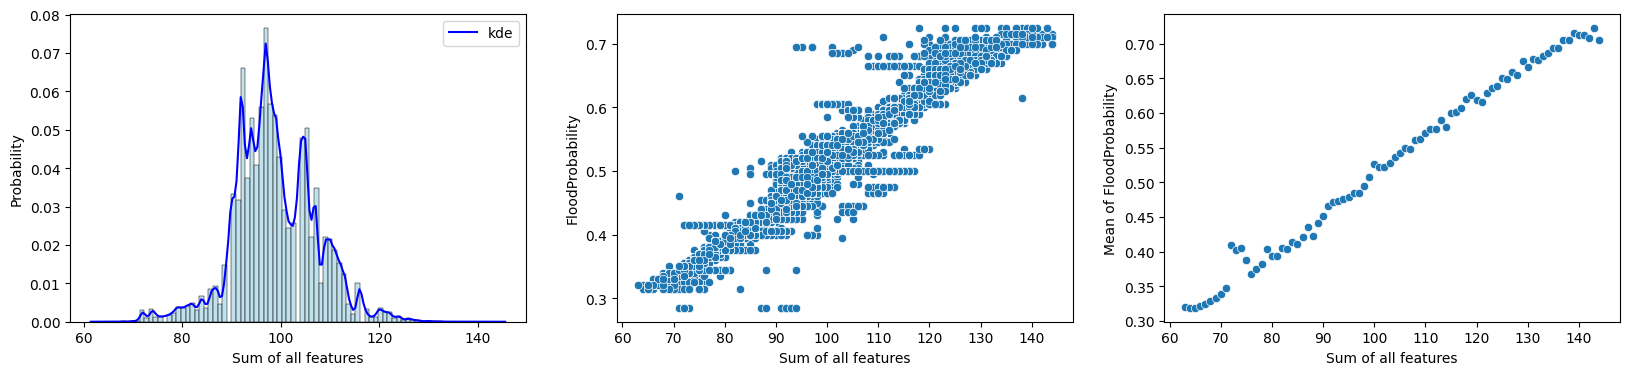

In [14]:
def plot_sum_features_vs_target(df, target):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20.0,4.0))
    
    x = df.sum(axis=1)
    sns.histplot(x=x, ax=ax1, stat='probability', kde=False, bins=87, color='lightblue')
    sns.kdeplot(x, ax=ax1, color='b', label='kde')
    ax1.set_xlabel('Sum of all features')
    ax1.legend(loc='upper right', title='')
    
    sns.scatterplot(x=x, y=target, ax=ax2)
    ax2.set_xlabel('Sum of all features')
    
    sns.scatterplot(target.groupby(x).mean(), ax=ax3)
    ax3.set_xlabel('Sum of all features')
    ax3.set_ylabel('Mean of FloodProbability')
    
    

display(md('''
As commented by @AMBROSM in the notebook [<u>"PSS4E5 EDA which makes sense"</u>](https://www.kaggle.com/code/ambrosm/pss4e5-eda-which-makes-sense?scriptVersionId=176598272&cellId=26), 
assuming that all variables were continuous, the linear regression analysis showed that **there was a high correlation between the sum of all features and FloodProbability**, 
with $R^2 = 0.844$ (approx). That's why in that notebook, the sum of all the features was proposed as a new feature.   

<br><br>
'''))

plot_sum_features_vs_target(train[initial_features], train['FloodProbability']) 



In [15]:
# Let's add new features based on statistics

def add_features(X):
    '''Add statistical features.'''

    X['max']      = X[initial_features].max(axis=1)
    X['min']      = X[initial_features].min(axis=1)
    X_mean        = X[initial_features].mean(axis=1)
    X['sum']      = X[initial_features].sum(axis=1)
    X['median']   = X[initial_features].median(axis=1)
    X['std']      = X[initial_features].std(axis=1)    
    X['mean+std'] = X_mean + X['std']
    X['mean-std'] = X_mean - X['std']
    new_stats_cols = ['max', 'min', 'sum', 'median', 'std', 'mean+std', 'mean-std']

    return X.astype(np.float32), initial_features + new_stats_cols, new_stats_cols


# add new features for train and test datasets
train, all_features, stats_features = add_features(train)
test,  _, _ = add_features(test)

md(f'''
All features = {all_features}   

**New train shape = {train.shape} (including target)**   

**New test shape = {test.shape}** 
''')


All features = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors', 'max', 'min', 'sum', 'median', 'std', 'mean+std', 'mean-std']   

**New train shape = (1117957, 28) (including target)**   

**New test shape = (745305, 27)** 


### CROSS VALIDATION STRATEGY

Two cross-validation strategies are proposed:   
- one for linear models, where the parameters are tested from a predefined set, and   
- another strategy for tree-based models, where the parameters are chosen randomly from a predefined interval.   

Both strategies return the model with the best cross-validation score.

In [16]:
def cross_validation_strategy_linear(df_train, features, models, param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0):
    '''
    Cross validation strategy for linear models.
    It updates VALIDATION_SCORES and VALIDATION_BEST_MODELS with the best solution found through cross-validation.
    Parameters:
       - n_folds : number of folds for cross validation.
       - models: dictionary of models.
       - param_grids: parameter dictionary for each model.
    '''
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for model in models:
        
        print('\n***********************************************************')
        print(f'******************** MODEL: {model}')
        print('***********************************************************')
            
        grid_reg = GridSearchCV(models[model], param_grid=param_grids[model], scoring=scoring, n_jobs=-1, cv=kf, verbose=verbose)
        grid_reg.fit(df_train[features], df_train['FloodProbability'])

        VALIDATION_SCORES[model] = grid_reg.best_score_
        
        print(f'{model}: best r2 (mean from folds) = {VALIDATION_SCORES[model]}')
        
        if len(param_grids[model])>0:
            print(f'---------- Best parameters: {grid_reg.best_params_}')
            
        VALIDATION_BEST_MODELS[model] = grid_reg.best_estimator_
            
            
            
def cross_validation_strategy_trees(df_train, features, models, param_dists, n_iter, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0):
    '''
    Cross validation strategy for tree-based models.
    It updates VALIDATION_SCORES and VALIDATION_BEST_MODELS with the best solution found through cross-validation.
    Parameters:
       - n_folds : number of folds for cross validation.
       - models: dictionary of models.
       - param_grids: parameter dictionary for each model.
       - n_iter: number of different parameter settings tested for each fold during cross-validation.
    '''    
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for model in models:
        
        print('\n***********************************************************')
        print(f'******************** MODEL: {model}')
        print('***********************************************************')
            
        ran_search = RandomizedSearchCV(models[model], param_distributions=param_dists[model], n_iter=n_iter, scoring=scoring, n_jobs=-1, cv=kf, verbose=verbose, random_state=1234)
        ran_search.fit(df_train[features], df_train['FloodProbability'])

        VALIDATION_SCORES[model] = ran_search.best_score_
        
        print(f'{model}: best r2 (mean from folds) = {VALIDATION_SCORES[model]}')
        
        if len(param_dists[model])>0:
            print(f'---------- Best parameters: {ran_search.best_params_}')
            
        VALIDATION_BEST_MODELS[model] = ran_search.best_estimator_

In [17]:
# Before we start training models, let's first define a function to sort the models according to their scores in descending order.

def sort_models_desc(verbose=False):
    # It sorts the models according to their scores in descending order.
    
    sorted_models = sorted(VALIDATION_SCORES.keys(), key=lambda k:VALIDATION_SCORES[k], reverse=True)
    if verbose: 
        print('Sorted models:', [(k, VALIDATION_SCORES[k]) for k in sorted_models])
    return sorted_models

### LINEAR MODELS TRAINING

**Model names: linear, ridge, and lasso**   
- models: Linear, Ridge, and Lasso, respectively    
- categorical columns = []  
- numerical columns = initial features 

In [18]:
%%time

models = {
    'linear': make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1)), 
    'ridge': Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Ridge())]),
    'lasso': Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Lasso(max_iter=100000))])
}

param_grids = {
    'linear': {}, 
    'ridge': {
        'regressor__alpha': [0.5, 1.0, 1.5, 2.0, 2.5] # default = 1
    },
    'lasso': {
        'regressor__alpha': [0.5, 1.0, 1.5, 2.0, 2.5] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features+stats_features, models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)

# linear: best r2 (mean from folds) = 0.8450895981544356
# ridge: best r2 (mean from folds) = 0.8450913420508996 ---------- Best parameters: {'regressor__alpha': 1.0}
# lasso: best r2 (mean from folds) = -3.0581422157949234e-06 ---------- Best parameters: {'regressor__alpha': 0.5}


***********************************************************
******************** MODEL: linear
***********************************************************
linear: best r2 (mean from folds) = 0.8450895981544356

***********************************************************
******************** MODEL: ridge
***********************************************************


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.26399e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.84973e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.96919e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24679e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

ridge: best r2 (mean from folds) = 0.8450913420508996
---------- Best parameters: {'regressor__alpha': 1.0}

***********************************************************
******************** MODEL: lasso
***********************************************************
lasso: best r2 (mean from folds) = -3.0581422157949234e-06
---------- Best parameters: {'regressor__alpha': 0.5}
CPU times: user 6.83 s, sys: 2.64 s, total: 9.47 s
Wall time: 29.5 s


In [19]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge with $R^2 = 0.845091$**

**Model names: linear_ohe, ridge_ohe, and lasso_ohe**   
- models: Linear, Ridge, and Lasso, respectively   
- categorical columns = initial features   
- numerical columns = []

In [20]:
%%time

models = {
    'linear_ohe': make_pipeline(
        OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
        LinearRegression(n_jobs=-1)), 
    'ridge_ohe': Pipeline([
        ('ohe', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')), 
        ('regressor', Ridge())]),
    'lasso_ohe': Pipeline([
        ('ohe', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')), 
        ('regressor', Lasso(max_iter=100000))])
}

param_grids = {
    'linear_ohe': {}, 
    'ridge_ohe': {
        'regressor__alpha': [0.5, 1.0, 1.5, 2.0] # default = 1
    },
    'lasso_ohe': {
        'regressor__alpha': [0.5, 1.0, 1.5, 2.0] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features, models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)

# linear_ohe: best r2 (mean from folds) = 0.8455641204378825
# ridge_ohe: best r2 (mean from folds) = 0.84557398702451 ---------- Best parameters: {'regressor__alpha': 0.5}
# lasso_ohe: best r2 (mean from folds) = -3.0547141622205844e-06 ---------- Best parameters: {'regressor__alpha': 0.5}


***********************************************************
******************** MODEL: linear_ohe
***********************************************************


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [16, 17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


linear_ohe: best r2 (mean from folds) = 0.8455641204378825

***********************************************************
******************** MODEL: ridge_ohe
***********************************************************
ridge_ohe: best r2 (mean from folds) = 0.84557398702451
---------- Best parameters: {'regressor__alpha': 0.5}

***********************************************************
******************** MODEL: lasso_ohe
***********************************************************
lasso_ohe: best r2 (mean from folds) = -3.0547141622205844e-06
---------- Best parameters: {'regressor__alpha': 0.5}
CPU times: user 2min 22s, sys: 31.2 s, total: 2min 53s
Wall time: 8min 41s


In [21]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe with $R^2 = 0.845574$**

**Model name: ridge_ohe_stats**   
- model: Ridge      
- categorical columns = initial features    
- numerical columns = ['max', 'min', 'sum', 'median', 'std', 'mean+std', 'mean-std']


***********************************************************
******************** MODEL: ridge_ohe_stats
***********************************************************
ridge_ohe_stats: best r2 (mean from folds) = 0.8459990794153962
---------- Best parameters: {'regressor__alpha': 12.5}
CPU times: user 22.7 s, sys: 14.6 s, total: 37.3 s
Wall time: 2min 59s


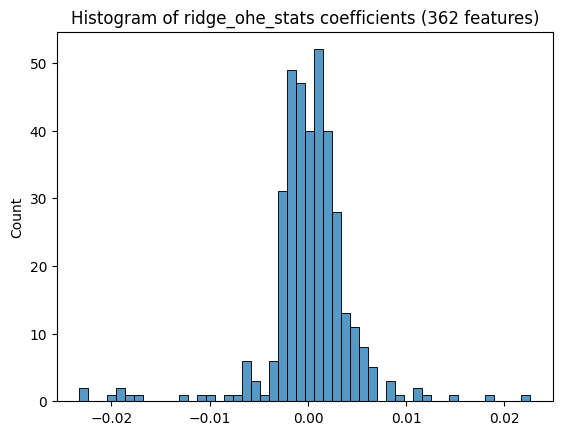

In [22]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'), initial_features),
        ('numerical', StandardScaler(), stats_features)
    ],
    n_jobs=4
)#.set_output(transform='pandas')

models = {
    'ridge_ohe_stats': Pipeline([
        ('preproc', preprocessor), 
        ('regressor', Ridge())]),
}

param_grids = {
    'ridge_ohe_stats': {
        'regressor__alpha': [12.0, 12.5, 13.0, 13.5] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features+stats_features, models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)


def plot_hist_ridge_coefs(model, bins=50):
    '''Histogram of Ridge coefficients'''
    title = 'Histogram of ' + model + ' coefficients (' + str (VALIDATION_BEST_MODELS[model]['regressor'].n_features_in_) + ' features)'
    sns.histplot(VALIDATION_BEST_MODELS[model]['regressor'].coef_, bins=bins).set(title=title)

    
plot_hist_ridge_coefs('ridge_ohe_stats')

# ridge_ohe_stats: best r2 (mean from folds) = 0.8459990794153962 ---------- Best parameters: {'regressor__alpha': 12.5}

In [23]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe_stats with $R^2 = 0.845999$**

**Model name: ridge_ohe_sum**
- model: Ridge      
- categorical columns = initial features + ['sum']    
- numerical columns = [] 


***********************************************************
******************** MODEL: ridge_ohe_sum
***********************************************************
ridge_ohe_sum: best r2 (mean from folds) = 0.866473480199779
---------- Best parameters: {'regressor__alpha': 1.0}
CPU times: user 30.5 s, sys: 10.8 s, total: 41.3 s
Wall time: 3min 4s


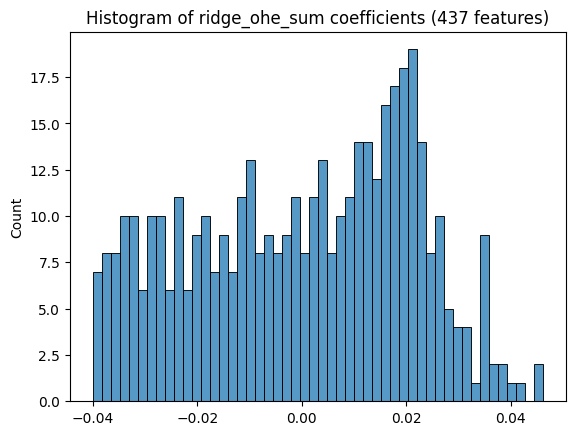

In [24]:
%%time

models = {
    'ridge_ohe_sum': Pipeline([
        ('ohe', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')), 
        ('regressor', Ridge())]),
}

param_grids = {
    'ridge_ohe_sum': {
        'regressor__alpha': [0.5, 1.0, 1.5, 2.0] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features+['sum'], models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)
   
plot_hist_ridge_coefs('ridge_ohe_sum')

# ridge_ohe_sum: best r2 (mean from folds) = 0.866473480199779 ---------- Best parameters: {'regressor__alpha': 1.0}
# leaderboard 0.86616

In [25]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe_sum with $R^2 = 0.866473$**

**Model name: ridge_ohe_sum_mmm**  
- model: Ridge    
- categorical columns = initial features + ['sum', 'median', 'min', 'max']   
- numerical columns = []   


***********************************************************
******************** MODEL: ridge_ohe_sum_mmm
***********************************************************
ridge_ohe_sum_mmm: best r2 (mean from folds) = 0.8665394916000906
---------- Best parameters: {'regressor__alpha': 0.5}
CPU times: user 33.8 s, sys: 11.9 s, total: 45.7 s
Wall time: 3min 26s


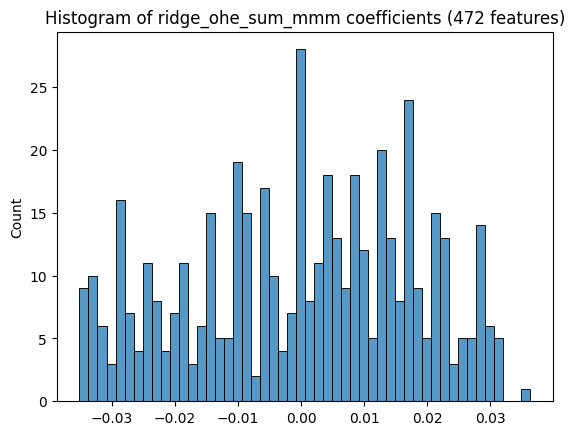

In [26]:
%%time

# model with high memory usage

models = {
    'ridge_ohe_sum_mmm': Pipeline([
        ('ohe', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')), 
        ('regressor', Ridge())]),
}

param_grids = {
    'ridge_ohe_sum_mmm': {
        'regressor__alpha': [0.3, 0.5, 0.7, 1.0] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features+['sum', 'median','min', 'max'], models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)

plot_hist_ridge_coefs('ridge_ohe_sum_mmm')

# ridge_ohe_sum_mmm: best r2 (mean from folds) = 0.8665394916000906 ---------- Best parameters: {'regressor__alpha': 0.5}
# leaderboard 0.86625

In [27]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe_sum_mmm with $R^2 = 0.866539$**

**Model name: ridge_ohe_num**   
- model: Ridge     
- categorical columns = initial features + ['sum', 'median', 'min', 'max']    
- numerical columns = ['std', 'mean+std', 'mean-std']


***********************************************************
******************** MODEL: ridge_ohe_num
***********************************************************
ridge_ohe_num: best r2 (mean from folds) = 0.8665629934486656
---------- Best parameters: {'regressor__alpha': 20.0}



Due to the large value of alpha, **𝛼 = 20.0**, **this is the model with the strongest regularization**: the histogram shows that most of the coefficients are very close to zero.


CPU times: user 32.6 s, sys: 18.4 s, total: 51 s
Wall time: 4min 12s


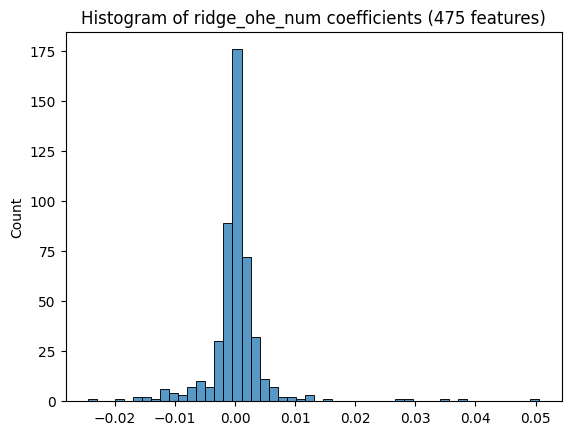

In [28]:
%%time

# model with high memory usage 

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore'), initial_features+['sum', 'median','min', 'max']),
        ('numerical', StandardScaler(), [col for col in stats_features if col not in ['sum', 'median','min', 'max']])
    ],
    n_jobs=4
)#.set_output(transform='pandas')

models = {
    'ridge_ohe_num': Pipeline([
        ('preproc', preprocessor), 
        ('regressor', Ridge())]),
}

param_grids = {
    'ridge_ohe_num': {
        'regressor__alpha': [19.0, 19.5, 20.0, 20.5] # default = 1
    }
}

cross_validation_strategy_linear(train, initial_features+stats_features, models=models, param_grids=param_grids, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=0)

display(md(f'''
Due to the large value of alpha, **𝛼 = {VALIDATION_BEST_MODELS['ridge_ohe_num']['regressor'].get_params()['alpha']}**, **this is the model with the strongest regularization**: the histogram shows that most of the coefficients are very close to zero.
'''))

plot_hist_ridge_coefs('ridge_ohe_num')

# ridge_ohe_num: best r2 (mean from folds) = 0.8665629934486656 ---------- Best parameters: {'regressor__alpha': 20.0}
# leaderboard 0.86627

In [29]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe_num with $R^2 = 0.866563$**

In [30]:
scores_so_far = pd.DataFrame({'model':sorted_models, 'scores':[VALIDATION_SCORES[m]*100 for m in sorted_models]})
display(md('''**Let's recap. The linear model scores are:**'''))
display(scores_so_far)
md('**The top three models have similar scores.**')

**Let's recap. The linear model scores are:**

,model,scores
0,ridge_ohe_num,86.656299
1,ridge_ohe_sum_mmm,86.653949
2,ridge_ohe_sum,86.647348
3,ridge_ohe_stats,84.599908
4,ridge_ohe,84.557399
5,linear_ohe,84.556412
6,ridge,84.509134
7,linear,84.508960
8,lasso_ohe,-0.000305
9,lasso,-0.000306


**The top three models have similar scores.**

### TREE-BASED MODELS TRAINING

**Model names: hgbr, xgb, lgbm, catb**   
- models: HistGradientBoosting, XGBoost, LightGBM, and CatBoost, respectively      
- categorical columns = []  
- numerical columns (they are assumed to be at least ordinal) = initial features   
- default parameters 

In [31]:
%%time

models = {
    'hgbr'  : HistGradientBoostingRegressor(random_state=0, early_stopping=True),
    'xgb'   : xgb.XGBRegressor(),
    'lgbm'  : lgbm.LGBMRegressor(n_jobs=4, force_col_wise=True),
    'catb'  : catb.CatBoostRegressor(verbose=0)
}

param_dists = {
    'hgbr'  : {},
    'xgb'   : {},
    'lgbm'  : {},
    'catb'  : {}
}

cross_validation_strategy_trees(train, initial_features, models=models, param_dists=param_dists, n_iter=5, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=4)

# hgbr: best r2 (mean from folds) = 0.7663900356736674
# xgb: best r2 (mean from folds) = 0.8102224465514645
# lgbm: best r2 (mean from folds) = 0.7664956515381685
# catb: best r2 (mean from folds) = 0.8462796479379551


***********************************************************
******************** MODEL: hgbr
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
hgbr: best r2 (mean from folds) = 0.7663900356736674

***********************************************************
******************** MODEL: xgb
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END ..................................., score=0.766 total time=  36.0s
[CV 2/5] END ..................................., score=0.811 total time=  25.3s
[CV 1/5] END ..................................., score=0.766 total time=  36.0s
[CV 1/5] END ..................................., score=0.809 total time=  25.4s
[CV 3/5] END ..................................., score=0.767 total time=  35.8s
[CV 5/5] END ..................................., score=0.767 total time=  24.2s
[CV 4/5] END .......................

In [32]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: ridge_ohe_num with $R^2 = 0.866563$**

**Model names: hgbr_sum, xgb_sum, lgbm_sum, catb_sum**   
- models: HistGradientBoosting, XGBoost, LightGBM, and CatBoost, respectively      
- categorical columns = []  
- numerical columns (they are assumed to be at least ordinal) = initial features + ['sum']   
- default parameters 

In [33]:
%%time

models = {
    'hgbr_sum': HistGradientBoostingRegressor(random_state=0, early_stopping=True),
    'xgb_sum' : xgb.XGBRegressor(),
    'lgbm_sum': lgbm.LGBMRegressor(n_jobs=4, force_col_wise=True),
    'catb_sum': catb.CatBoostRegressor(verbose=0)
}

param_dists = {
    'hgbr_sum': {},
    'xgb_sum' : {},
    'lgbm_sum': {},
    'catb_sum': {}
}

cross_validation_strategy_trees(train, initial_features+['sum'], models=models, param_dists=param_dists, n_iter=5, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=4)

# hgbr_sum: best r2 (mean from folds) = 0.8671038169274808
# xgb_sum: best r2 (mean from folds) = 0.8671696523225034
# lgbm_sum: best r2 (mean from folds) = 0.8672152403381066
# catb_sum: best r2 (mean from folds) = 0.8674858021511371


***********************************************************
******************** MODEL: hgbr_sum
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.867 total time=  14.4s
[CV 2/5] END ..................................., score=0.868 total time=  14.6s
[CV 3/5] END ..................................., score=0.867 total time=  15.3s
[CV 4/5] END ..................................., score=0.867 total time=  14.5s
[CV 5/5] END ..................................., score=0.867 total time=  15.1s
hgbr_sum: best r2 (mean from folds) = 0.8671038169274808

***********************************************************
******************** MODEL: xgb_sum
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.867 total time=  18.9s
[CV 2/5] END ...........

In [34]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: catb_sum with $R^2 = 0.867486$**

**Model names: hgbr_stats, xgb_stats, lgbm_stats, catb_stats**   
- models: HistGradientBoosting, XGBoost, LightGBM, and CatBoost, respectively      
- categorical columns = []  
- numerical columns (they are assumed to be at least ordinal) = initial features + ['max', 'min', 'sum', 'median', 'std', 'mean+std', 'mean-std']   
- default parameters 

In [35]:
%%time

models = {
    'hgbr_stats': HistGradientBoostingRegressor(random_state=0, early_stopping=True),
    'xgb_stats' : xgb.XGBRegressor(),
    'lgbm_stats': lgbm.LGBMRegressor(n_jobs=4, force_col_wise=True),
    'catb_stats': catb.CatBoostRegressor(verbose=0)
}

param_dists = {
    'hgbr_stats': {},
    'xgb_stats' : {},
    'lgbm_stats': {},
    'catb_stats': {}
}

cross_validation_strategy_trees(train, initial_features+stats_features, models=models, param_dists=param_dists, n_iter=5, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=4)

# hgbr_stats: best r2 (mean from folds) = 0.868617180627823
# xgb_stats: best r2 (mean from folds) = 0.8685924591809776
# lgbm_stats: best r2 (mean from folds) = 0.8687118393234214
# catb_stats: best r2 (mean from folds) = 0.8688582367145432


***********************************************************
******************** MODEL: hgbr_stats
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.868 total time=  19.3s
[CV 2/5] END ..................................., score=0.869 total time=  18.2s
[CV 3/5] END ..................................., score=0.868 total time=  18.4s
[CV 4/5] END ..................................., score=0.869 total time=  17.9s
[CV 5/5] END ..................................., score=0.869 total time=  18.1s
hgbr_stats: best r2 (mean from folds) = 0.868617180627823

***********************************************************
******************** MODEL: xgb_stats
***********************************************************
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.868 total time=  25.2s
[CV 2/5] END ......

In [36]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: catb_stats with $R^2 = 0.868858$**

**Model names: hgbr_param, xgb_param, lgbm_param, catb_param**   
- models: HistGradientBoosting, XGBoost, LightGBM, and CatBoost, respectively      
- categorical columns = []  
- numerical columns (they are assumed to be at least ordinal) = initial features + ['max', 'min', 'sum', 'median', 'std', 'mean+std', 'mean-std']   
- choose the best parameters from a predefined interval

In [37]:
%%time

models = {
    'hgbr_param': Pipeline([('regressor', HistGradientBoostingRegressor(random_state=0, max_iter=200, n_iter_no_change=50, early_stopping=True))]),
    'xgb_param' : Pipeline([('regressor', xgb.XGBRegressor())]),
    'lgbm_param': Pipeline([('regressor', lgbm.LGBMRegressor(n_jobs=4, force_col_wise=True))]),
    'catb_param' : Pipeline([('regressor', catb.CatBoostRegressor(verbose=0))])
}

param_dists = {
    'hgbr_param': {
        'regressor__max_depth': stats.randint(5, 15)
    },
    'xgb_param' : {
        'regressor__max_leaves': stats.randint(31, 512), 
        'regressor__subsample': stats.uniform(0.8, 0.2) # default = 1.0
    },
    'lgbm_param': {
        'regressor__num_leaves': stats.randint(31, 512), 
        'regressor__subsample': stats.uniform(0.8, 0.2) # default = 1.0
    },
    'catb_param': {
        'regressor__max_depth': stats.randint(5, 15), # default = 6
        'regressor__colsample_bylevel': stats.uniform(0.8, 0.2) # default = 1.0
    }
}

cross_validation_strategy_trees(train, initial_features+stats_features, models=models, param_dists=param_dists, n_iter=5, scoring='r2', random_state=42, n_folds=N_FOLDS, verbose=4)

# hgbr_param: best r2 (mean from folds) = 0.8687142090612753 ---------- Best parameters: {'regressor__max_depth': 10}
# xgb_param: best r2 (mean from folds) = 0.8686072456502976 ---------- Best parameters: {'regressor__max_leaves': 183, 'regressor__subsample': 0.9542719837724802}
# lgbm_param: best r2 (mean from folds) = 0.8689447978729902 ---------- Best parameters: {'regressor__num_leaves': 84, 'regressor__subsample': 0.8875455478014229}
# catb_param: best r2 (mean from folds) = 0.8688402174169949 ---------- Best parameters: {'regressor__colsample_bylevel': 0.9570717167427539, 'regressor__max_depth': 6}


***********************************************************
******************** MODEL: hgbr_param
***********************************************************
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ............regressor__max_depth=8;, score=0.869 total time=  22.9s
[CV 2/5] END ............regressor__max_depth=8;, score=0.869 total time=  24.3s
[CV 3/5] END ............regressor__max_depth=8;, score=0.868 total time=  23.7s
[CV 4/5] END ............regressor__max_depth=8;, score=0.869 total time=  23.6s
[CV 5/5] END ............regressor__max_depth=8;, score=0.869 total time=  24.5s
[CV 1/5] END ...........regressor__max_depth=11;, score=0.869 total time=  24.1s
[CV 2/5] END ...........regressor__max_depth=11;, score=0.869 total time=  24.0s
[CV 3/5] END ...........regressor__max_depth=11;, score=0.868 total time=  24.2s
[CV 4/5] END ...........regressor__max_depth=11;, score=0.869 total time=  24.6s
[CV 5/5] END ...........regressor__max_depth=11;, s

In [38]:
sorted_models = sort_models_desc()
md(f'''**The best model so far is: {sorted_models[0]} with $R^2 = {VALIDATION_SCORES[sorted_models[0]]:6f}$**''')

**The best model so far is: lgbm_param with $R^2 = 0.868945$**

In [39]:
scores_so_far = pd.DataFrame({'model':sorted_models, 'scores':[VALIDATION_SCORES[m]*100 for m in sorted_models]})
display(md('''**Let's recap. The model scores are:**'''))
display(scores_so_far)

**Let's recap. The model scores are:**

,model,scores
0,lgbm_param,86.894480
1,catb_stats,86.885824
2,catb_param,86.884022
3,hgbr_param,86.871421
4,lgbm_stats,86.871184
5,hgbr_stats,86.861718
6,xgb_param,86.860725
7,xgb_stats,86.859246
8,catb_sum,86.748580
9,lgbm_sum,86.721524


## SUBMISSION

In [40]:
def make_prediction(n=4):
    '''It takes the n highest scored models to make predictions.'''
    
    test_pred = np.zeros(len(test), dtype=float)
    for model in sorted_models[:n]:
        test_pred += VALIDATION_BEST_MODELS[model].predict(test[initial_features+stats_features])
    
    print(f'cross validation score (for n={n}) = {np.mean([VALIDATION_SCORES[model] for model in sorted_models[:n]])}')
    return test_pred / n


submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

test_prediction = make_prediction(4) # take top 4 models
submission['FloodProbability'] = test_prediction
submission.to_csv('submission_4_best.csv', index=False)
# cross validation score = 0.8688393652664509 - leaderboard = 0.86886

test_prediction = make_prediction(8) # take top 8 models
submission['FloodProbability'] = test_prediction
submission.to_csv('submission_8_best.csv', index=False)
# cross validation score = 0.8687357732310403 - leaderboard = 0.86884

submission.head()

cross validation score (for n=4) = 0.8688393652664509
cross validation score (for n=8) = 0.8687357732310403


,id,FloodProbability
0,1117957,0.578000
1,1117958,0.455298
2,1117959,0.449698
3,1117960,0.466668
4,1117961,0.467031
